In [1]:
#Python libraries
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt 
import MetaTrader5 as mt5
import tensorflow as tf
import numpy as np
import pandas as pd
import tf2onnx
from sklearn.model_selection import train_test_split
from sys import argv


In [2]:
#check tensorflow version
print(tf.__version__)

2.15.0


In [3]:
#initialize MetaTrader5 for history data
if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())
    quit()

In [5]:
#show file path
file_path=terminal_info.data_path+"\\MQL5\\Files\\"
print(file_path)

C:\Users\User\AppData\Roaming\MetaQuotes\Terminal\010E047102812FC0C18890992854220E\MQL5\Files\


In [6]:
#data path to save the model
data_path='C:\\Users\\User\\AppData\\Roaming\\MetaQuotes\\Terminal\\010E047102812FC0C18890992854220E\\MQL5\\Files\\' 
last_index=data_path.rfind("\\")+1
data_path=data_path[0:last_index]
print("data path to save onnx model",data_path)

data path to save onnx model C:\Users\User\AppData\Roaming\MetaQuotes\Terminal\010E047102812FC0C18890992854220E\MQL5\Files\


In [7]:
#set start and end dates for history data
from datetime import timedelta,datetime
end_date = datetime(2024, 1, 1, 0)
start_date = end_date - timedelta(days=120)

#print start and end dates
print("data start date=",start_date)
print("data end date=",end_date)

data start date= 2023-09-03 00:00:00
data end date= 2024-01-01 00:00:00


In [8]:
#get EURUSD rates (H1) from start_date to end_date
eurusd_rates = mt5.copy_rates_range("EURUSD", mt5.TIMEFRAME_H1, start_date, end_date)

In [9]:
#create dataframe
df = pd.DataFrame(eurusd_rates)
df['time'] = pd.to_datetime(df['time'],unit='s')
#df.index = df.pop('time')

In [10]:
df.head()

,time,open,high,low,close,tick_volume,spread,real_volume
0,2023-09-04 00:00:00,1.07753,1.07780,1.07712,1.07736,337,2,0
1,2023-09-04 01:00:00,1.07747,1.07772,1.07719,1.07733,641,0,0
2,2023-09-04 02:00:00,1.07728,1.07766,1.07716,1.07757,683,0,0
3,2023-09-04 03:00:00,1.07756,1.07802,1.07733,1.07789,1036,0,0
4,2023-09-04 04:00:00,1.07788,1.07822,1.07749,1.07766,2018,0,0


In [11]:
df.tail()

,time,open,high,low,close,tick_volume,spread,real_volume
2010,2023-12-29 19:00:00,1.10606,1.10668,1.10529,1.10640,2398,0,0
2011,2023-12-29 20:00:00,1.10642,1.10642,1.10492,1.10530,3070,0,0
2012,2023-12-29 21:00:00,1.10538,1.10540,1.10381,1.10406,1723,0,0
2013,2023-12-29 22:00:00,1.10409,1.10508,1.10384,1.10410,1475,0,0
2014,2023-12-29 23:00:00,1.10410,1.10410,1.10342,1.10372,818,0,0


In [12]:
df.columns

Index(['time', 'open', 'high', 'low', 'close', 'tick_volume', 'spread',
       'real_volume'],
      dtype='object')

In [13]:
#prepare close prices only
data = df.filter(['close']).values

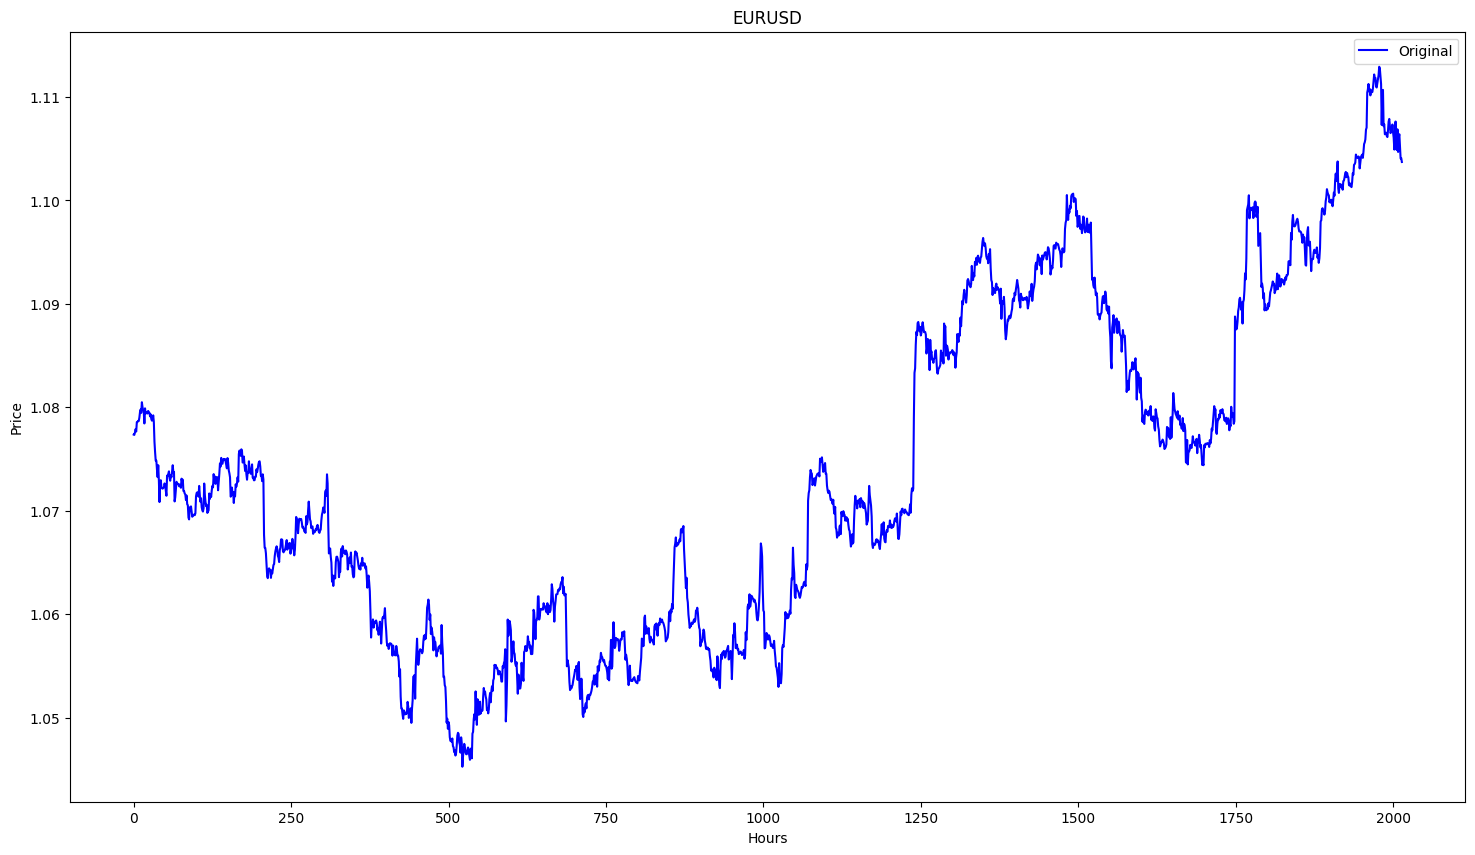

In [14]:
#show close prices
plt.figure(figsize = (18,10))
plt.plot(data,'b',label = 'Original')
plt.xlabel("Hours")
plt.ylabel("Price")
plt.title("EURUSD")
plt.legend()

In [15]:
#scale data using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

In [16]:
#training size is 80% of the data
training_size = int(len(scaled_data)*0.80) 
print("training size:",training_size)

training size: 1612


In [17]:
#create train data and check size
train_data_initial = scaled_data[0:training_size,:]


In [18]:
#create test data and check size
test_data_initial= scaled_data[training_size:,:1]
print(len(test_data_initial))

403


In [19]:
#split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
       #find the end of this pattern
       end_ix = i + n_steps
       #check if we are beyond the sequence
       if end_ix > len(sequence)-1:
          break
       #gather input and output parts of the pattern
       seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
       X.append(seq_x)
       y.append(seq_y)
    return np.array(X), np.array(y)

In [20]:
#split into samples
time_step = 120
x_train, y_train = split_sequence(train_data_initial, time_step)
x_test, y_test = split_sequence(test_data_initial, time_step)


In [21]:

#reshape input to be [samples, time steps, features] which is required for LSTM
x_train =x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [22]:
#show shape of train data
x_train.shape

(1492, 120, 1)

In [23]:
#show shape of test data
x_test.shape

(283, 120, 1)

In [24]:
#import keras libraries for the model
import math
from keras.models import Sequential
from keras.layers import Dense,Activation,Conv1D,MaxPooling1D,Dropout
from keras.layers import LSTM
from keras.utils import plot_model
from keras.metrics import RootMeanSquaredError as rmse
from keras import optimizers

In [25]:
#define the model
model = Sequential()
model.add(Conv1D(filters=256, kernel_size=2,activation='relu',padding = 'same',input_shape=(120,1)))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100, return_sequences = True))
model.add(Dropout(0.3))
model.add(LSTM(100, return_sequences = False))
model.add(Dropout(0.3))
model.add(Dense(units=1, activation = None ))
model.compile(optimizer='adam', loss= 'mse' , metrics = [rmse()])

In [26]:
#show model
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 120, 256)          768       
                                                                 
 max_pooling1d (MaxPooling1  (None, 60, 256)           0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 60, 100)           142800    
                                                                 
 dropout (Dropout)           (None, 60, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                        

In [29]:
#measure time
import time 
time_calc_start = time.time()

#fit model with 160 epochs
history=model.fit(x_train,y_train,epochs=50,validation_data=(x_test,y_test),batch_size=32,verbose=1)

#calculate time
fit_time_seconds = time.time() - time_calc_start
print("fit time =",fit_time_seconds," seconds.")

Epoch 1/50
47/47 [==============================] - 7s 155ms/step - loss: 0.0011 - root_mean_squared_error: 0.0335 - val_loss: 9.1183e-04 - val_root_mean_squared_error: 0.0302
Epoch 2/50
47/47 [==============================] - 7s 150ms/step - loss: 0.0012 - root_mean_squared_error: 0.0352 - val_loss: 4.5242e-04 - val_root_mean_squared_error: 0.0213
Epoch 3/50
47/47 [==============================] - 8s 165ms/step - loss: 0.0013 - root_mean_squared_error: 0.0367 - val_loss: 4.8782e-04 - val_root_mean_squared_error: 0.0221
Epoch 4/50
47/47 [==============================] - 7s 156ms/step - loss: 0.0011 - root_mean_squared_error: 0.0333 - val_loss: 4.7074e-04 - val_root_mean_squared_error: 0.0217
Epoch 5/50
47/47 [==============================] - 7s 149ms/step - loss: 0.0011 - root_mean_squared_error: 0.0331 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0399
Epoch 6/50
47/47 [==============================] - 7s 151ms/step - loss: 9.8863e-04 - root_mean_squared_error: 0.0314 - val

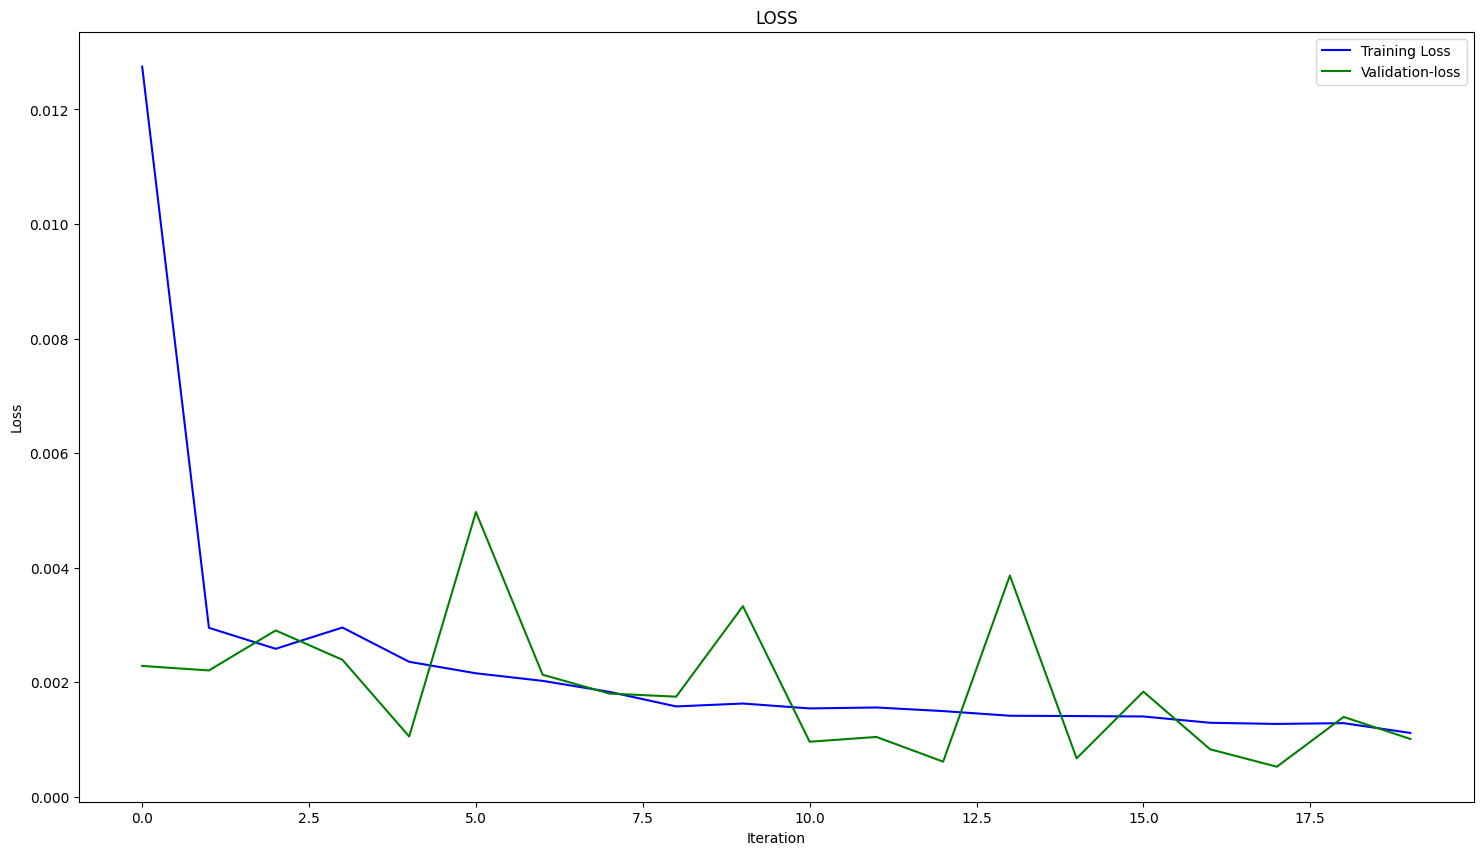

In [28]:
#show iteration-loss graph for training and validation
plt.figure(figsize = (18,10))
plt.plot(history.history['loss'],label='Training Loss',color='b')
plt.plot(history.history['val_loss'],label='Validation-loss',color='g')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("LOSS")
plt.legend()

In [114]:
#evaluate training data
model.evaluate(x_train,y_train, batch_size = 32)

47/47 [==============================] - 2s 41ms/step - loss: 3.6065e-04 - root_mean_squared_error: 0.0190


[0.00036065460881218314, 0.018990907818078995]

In [115]:
#evaluate testing data
model.evaluate(x_test,y_test, batch_size = 32)

9/9 [==============================] - 0s 37ms/step - loss: 0.0034 - root_mean_squared_error: 0.0583


[0.003393451450392604, 0.05825333669781685]

In [116]:
#prediction using training data
train_predict = model.predict(x_train)
plot_y_train = y_train.reshape(-1,1)

47/47 [==============================] - 4s 34ms/step


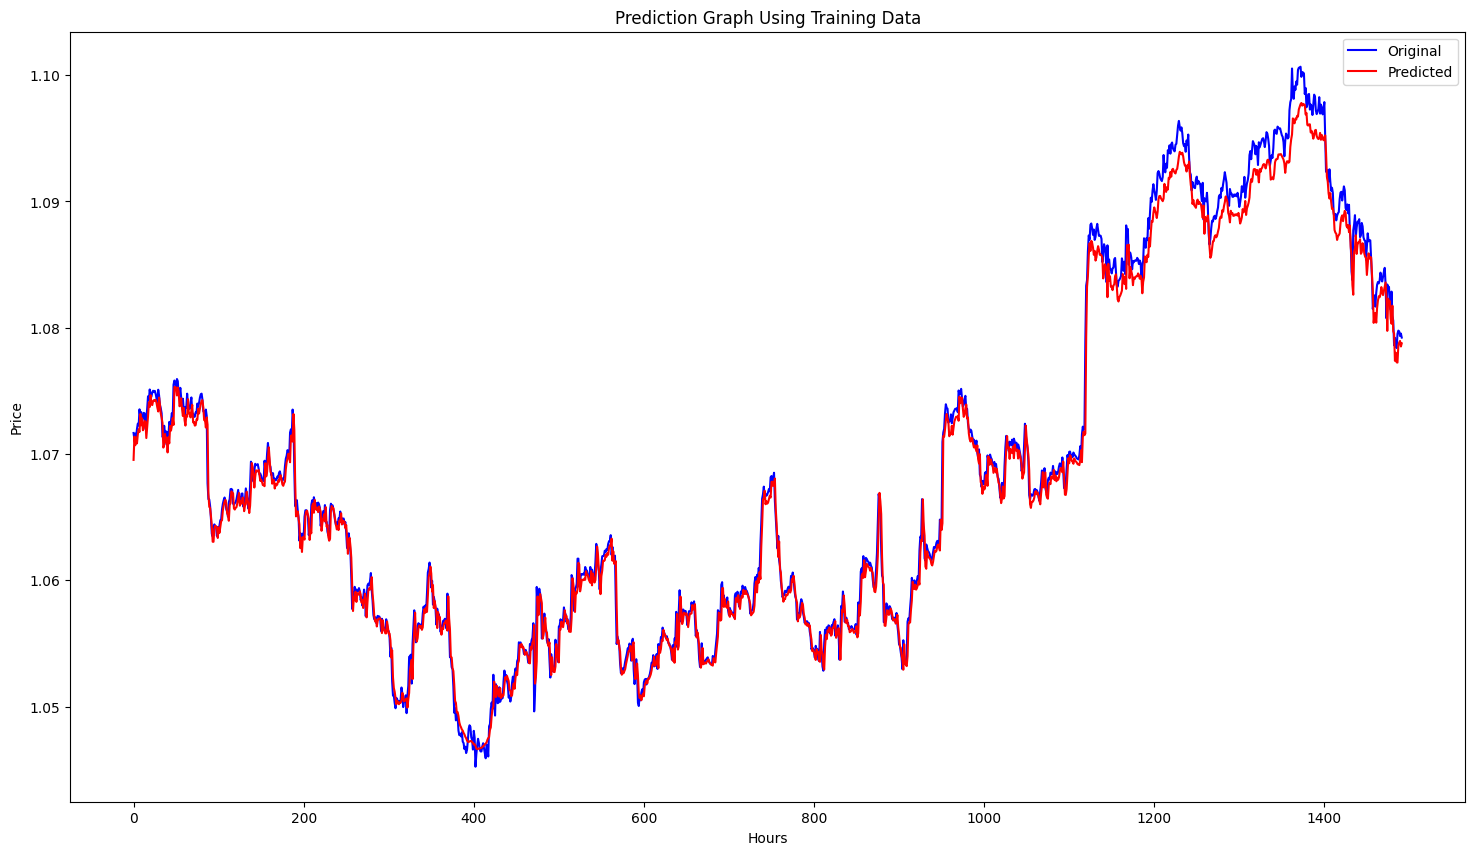

In [117]:
#show actual vs predicted (training) graph
plt.figure(figsize=(18,10))
plt.plot(scaler.inverse_transform(plot_y_train),color = 'b', label = 'Original')
plt.plot(scaler.inverse_transform(train_predict),color='red', label = 'Predicted')
plt.title("Prediction Graph Using Training Data")
plt.xlabel("Hours")
plt.ylabel("Price")
plt.legend()
plt.show()

In [118]:
#prediction using testing data
test_predict = model.predict(x_test)
plot_y_test = y_test.reshape(-1,1)

9/9 [==============================] - 0s 36ms/step


In [119]:
#calculate metrics
from sklearn import metrics
from sklearn.metrics import r2_score
#transform data to real values
value1=scaler.inverse_transform(plot_y_test)
value2=scaler.inverse_transform(test_predict)
#calc score
score = np.sqrt(metrics.mean_squared_error(value1,value2))
print("RMSE         : {}".format(score))
print("MSE          :", metrics.mean_squared_error(value1,value2))
print("R2 score     :",metrics.r2_score(value1,value2))

RMSE         : 0.003942582403412133
MSE          : 1.554395600769499e-05
R2 score     : 0.753777231253467


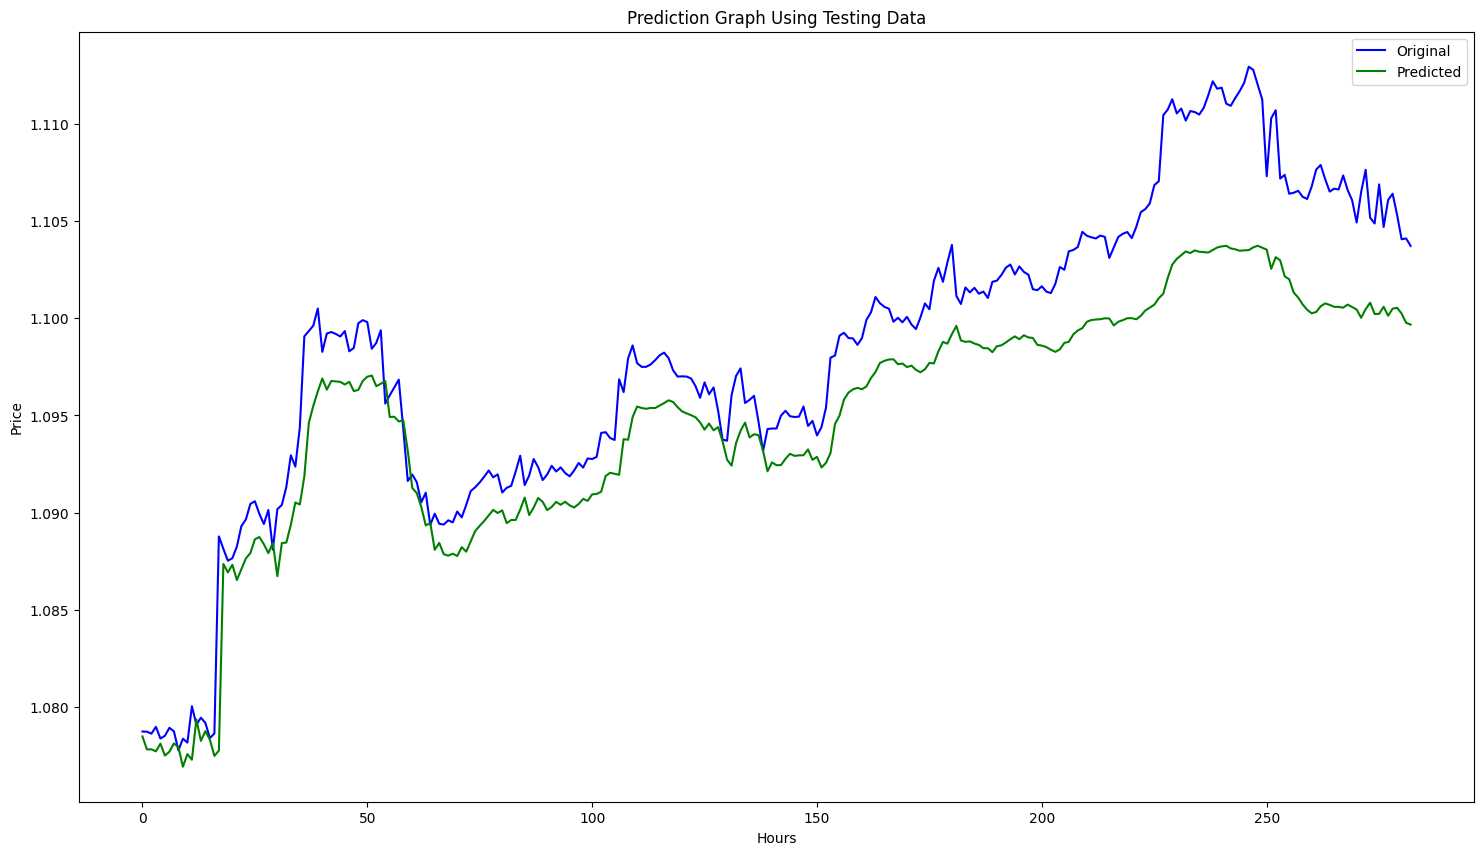

In [120]:
#show actual vs predicted (testing) graph
plt.figure(figsize=(18,10))
plt.plot(scaler.inverse_transform(plot_y_test),color = 'b',  label = 'Original')
plt.plot(scaler.inverse_transform(test_predict),color='g', label = 'Predicted')
plt.title("Prediction Graph Using Testing Data")
plt.xlabel("Hours")
plt.ylabel("Price")
plt.legend()
plt.show()

In [121]:
# save model to ONNX
output_path = data_path+"model.eurusd.H1.120.onnx"
onnx_model = tf2onnx.convert.from_keras(model, output_path=output_path)
print(f"model saved to {output_path}")

output_path = file_path+"model.eurusd.H1.120.onnx"
onnx_model = tf2onnx.convert.from_keras(model, output_path=output_path)
print(f"saved model to {output_path}")

# finish
mt5.shutdown()

model saved to C:\Users\User\AppData\Roaming\MetaQuotes\Terminal\010E047102812FC0C18890992854220E\MQL5\Files\model.eurusd.H1.120.onnx
saved model to C:\Users\User\AppData\Roaming\MetaQuotes\Terminal\010E047102812FC0C18890992854220E\MQL5\Files\model.eurusd.H1.120.onnx


True

# SECOND APROACH

In [59]:
# python libraries
import MetaTrader5 as mt5
import tensorflow as tf
import numpy as np
import pandas as pd
import tf2onnx

In [60]:
# input parameters
inp_model_name = "model.EurUsd.H1.120.onnx"
inp_history_size = 120

if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())
    quit()

In [61]:
#data path to save the model
data_path='C:\\Users\\User\\AppData\\Roaming\\MetaQuotes\\Terminal\\010E047102812FC0C18890992854220E\\MQL5\\Files\\' 
last_index=data_path.rfind("\\")+1
data_path=data_path[0:last_index]
print("data path to save onnx model",data_path)

data path to save onnx model C:\Users\User\AppData\Roaming\MetaQuotes\Terminal\010E047102812FC0C18890992854220E\MQL5\Files\


In [62]:
# set start and end dates for history data
from datetime import timedelta, datetime
#end_date = datetime.now()
end_date = datetime(2023, 1, 1, 0)
start_date = end_date - timedelta(days=inp_history_size)

# print start and end dates
print("data start date =",start_date)
print("data end date =",end_date)

data start date = 2022-09-03 00:00:00
data end date = 2023-01-01 00:00:00


In [63]:
#get EURUSD rates (H1) from start_date to end_date
eurusd_rates = mt5.copy_rates_range("EURUSD", mt5.TIMEFRAME_H1, start_date, end_date)

#create dataframe
df = pd.DataFrame(eurusd_rates)

df['time'] = pd.to_datetime(df['time'],unit='s')

df.head()

,time,open,high,low,close,tick_volume,spread,real_volume
0,2022-09-02 23:00:00,0.99530,0.99609,0.99518,0.99564,1467,0,0
1,2022-09-05 00:00:00,0.99208,0.99348,0.99153,0.99207,552,9,0
2,2022-09-05 01:00:00,0.99304,0.99346,0.99032,0.99221,2697,0,0
3,2022-09-05 02:00:00,0.99221,0.99262,0.99070,0.99079,1640,0,0
4,2022-09-05 03:00:00,0.99079,0.99289,0.99076,0.99156,2912,0,0


In [71]:
# scale data
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

# training size is 80% of the data
training_size = int(len(scaled_data)*0.80) 
print("Training_size:",training_size)
train_data_initial = scaled_data[0:training_size,:]
test_data_initial = scaled_data[training_size:,:1]

Training_size: 1651


In [65]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
       # find the end of this pattern
       end_ix = i + n_steps
       # check if we are beyond the sequence
       if end_ix > len(sequence)-1:
          break
       # gather input and output parts of the pattern
       seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
       X.append(seq_x)
       y.append(seq_y)
    return np.array(X), np.array(y)

In [66]:
# split into samples
time_step = inp_history_size
x_train, y_train = split_sequence(train_data_initial, time_step)
x_test, y_test = split_sequence(test_data_initial, time_step)

# reshape input to be [samples, time steps, features] which is required for LSTM
x_train =x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [ ]:
# define model
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv1D, MaxPooling1D, Dropout, Flatten, LSTM
from keras.metrics import RootMeanSquaredError as rmse
model = Sequential()
model.add(Conv1D(filters=256, kernel_size=2, activation='relu',padding = 'same',input_shape=(inp_history_size,1)))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100, return_sequences = True))
model.add(Dropout(0.3))
model.add(LSTM(100, return_sequences = False))
model.add(Dropout(0.3))
model.add(Dense(units=1, activation = 'sigmoid'))
model.compile(optimizer='adam', loss= 'mse' , metrics = [rmse()])

In [68]:
# model training for 300 epochs
history = model.fit(x_train, y_train, epochs = 100 , validation_data = (x_test,y_test), batch_size=32, verbose=2)

Epoch 1/100
48/48 - 5s - loss: 7.2132e-04 - root_mean_squared_error: 0.0269 - val_loss: 7.5950e-04 - val_root_mean_squared_error: 0.0276 - 5s/epoch - 95ms/step
Epoch 2/100
48/48 - 4s - loss: 7.1384e-04 - root_mean_squared_error: 0.0267 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0340 - 4s/epoch - 89ms/step
Epoch 3/100
48/48 - 4s - loss: 6.7287e-04 - root_mean_squared_error: 0.0259 - val_loss: 7.4988e-04 - val_root_mean_squared_error: 0.0274 - 4s/epoch - 87ms/step
Epoch 4/100
48/48 - 4s - loss: 7.1682e-04 - root_mean_squared_error: 0.0268 - val_loss: 9.0232e-04 - val_root_mean_squared_error: 0.0300 - 4s/epoch - 89ms/step
Epoch 5/100
48/48 - 4s - loss: 7.3750e-04 - root_mean_squared_error: 0.0272 - val_loss: 7.1870e-04 - val_root_mean_squared_error: 0.0268 - 4s/epoch - 89ms/step
Epoch 6/100
48/48 - 4s - loss: 6.8372e-04 - root_mean_squared_error: 0.0261 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0429 - 4s/epoch - 87ms/step
Epoch 7/100
48/48 - 4s - loss: 7.4594e-04 - root

In [69]:
# evaluate training data
train_loss, train_rmse = model.evaluate(x_train,y_train, batch_size = 32)
print(f"train_loss={train_loss:.3f}")
print(f"train_rmse={train_rmse:.3f}")

# evaluate testing data
test_loss, test_rmse = model.evaluate(x_test,y_test, batch_size = 32)
print(f"test_loss={test_loss:.3f}")
print(f"test_rmse={test_rmse:.3f}")

# save model to ONNX
output_path = data_path+inp_model_name
onnx_model = tf2onnx.convert.from_keras(model, output_path=output_path)
print(f"saved model to {output_path}")

# finish
mt5.shutdown()

48/48 [==============================] - 2s 37ms/step - loss: 5.4427e-04 - root_mean_squared_error: 0.0233
train_loss=0.001
train_rmse=0.023
10/10 [==============================] - 0s 34ms/step - loss: 8.4725e-04 - root_mean_squared_error: 0.0291
test_loss=0.001
test_rmse=0.029
saved model to C:\Users\User\AppData\Roaming\MetaQuotes\Terminal\010E047102812FC0C18890992854220E\MQL5\Files\model.EurUsd.H1.120.onnx


True

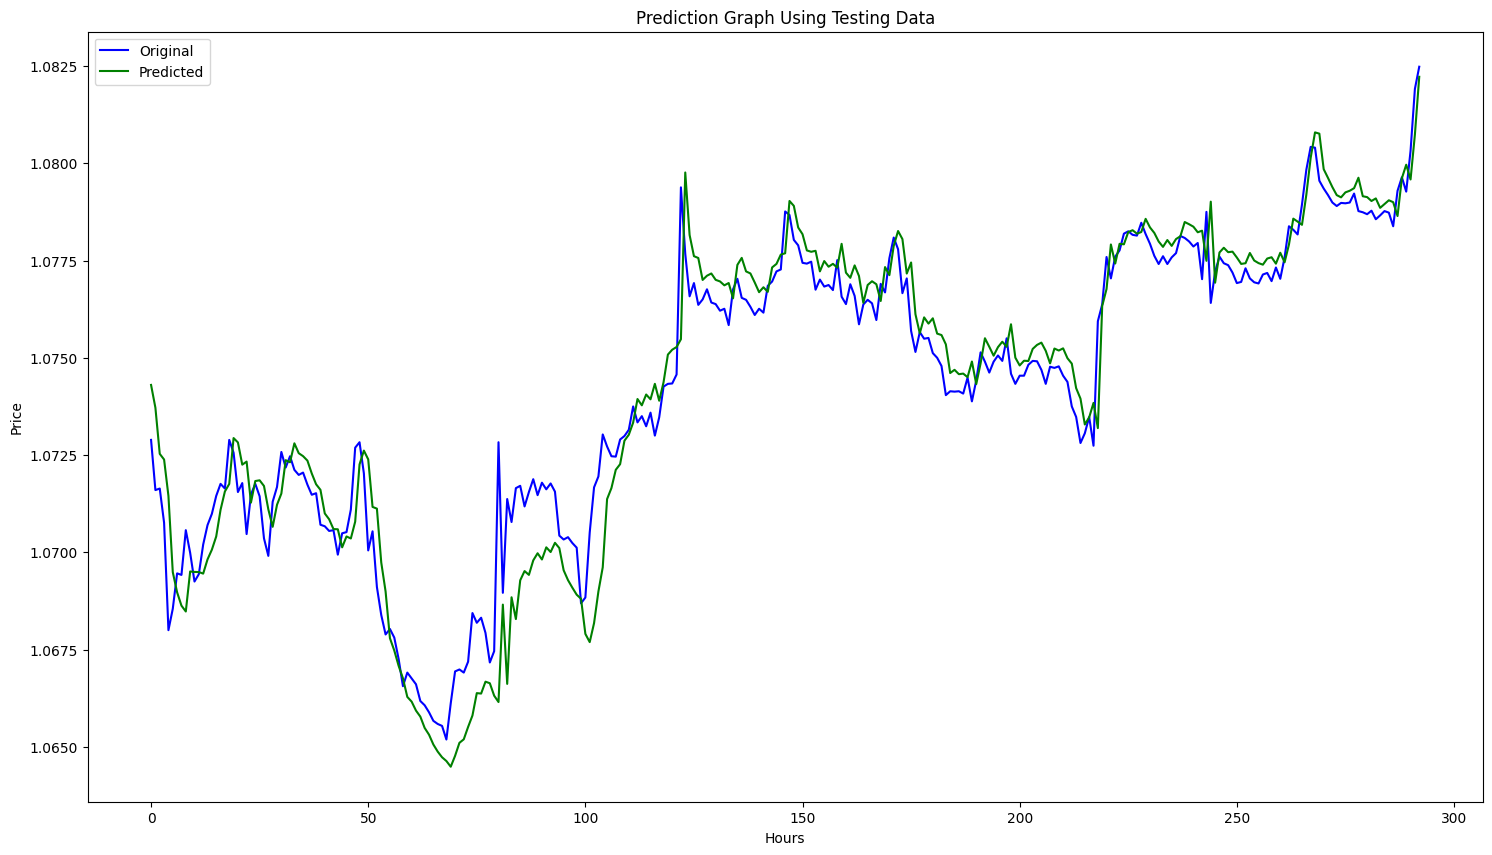

In [70]:
#show actual vs predicted (testing) graph
plt.figure(figsize=(18,10))
plt.plot(scaler.inverse_transform(plot_y_test),color = 'b',  label = 'Original')
plt.plot(scaler.inverse_transform(test_predict),color='g', label = 'Predicted')
plt.title("Prediction Graph Using Testing Data")
plt.xlabel("Hours")
plt.ylabel("Price")
plt.legend()
plt.show()

In [ ]:
#prediction using testing data
test_predict = model.predict(x_test)
plot_y_test = y_test.reshape(-1,1)